In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns
import pandas as pd
from scipy import signal
from importlib import reload

import winsound as sd
import pickle
import sys
import os

In [2]:
# load
cd = os.getcwd()
path = os.path.dirname(cd)
    
with open(path+'//Data_final.pkl', 'rb') as file:
    Filt_idata = pickle.load(file)
    Filt_gdata = pickle.load(file)
    Filt_glen = pickle.load(file)
    F_DataLen = pickle.load(file)
    
    Af_py = pickle.load(file)
    Af_in = pickle.load(file)
    
    In_py_list = pickle.load(file)
    In_in_list = pickle.load(file)

In [3]:
# 전반적인 cue 200개에 대한 결과
path_results = '//module//Results_trade_off5'

with open(path+path_results+'//Results-tradeoff_DG_vf0.pkl', 'rb') as file:
    Success = pickle.load(file)
    Fail = pickle.load(file)
    If_fail = pickle.load(file)
    Winfin = pickle.load(file)

    DG_E_listL = pickle.load(file)

In [4]:
# 전반적인 cue 200개에 대한 결과
path_results = '//module//Results_trade_off5'

with open(path+path_results+'//Results-tradeoff_DG_vf1.pkl', 'rb') as file:
    Success = pickle.load(file)
    Fail = pickle.load(file)
    If_fail = pickle.load(file)
    Winfin = pickle.load(file)

    DG_E_listN = pickle.load(file)

In [5]:
# 전반적인 cue 200개에 대한 결과
path_results = '//module//Results_trade_off5'

for n in range(4):
    with open(path+path_results+'//Results-tradeoff_vf0%d.pkl' %(n+1), 'rb') as file:
        globals()["Success{}".format(n+1)] = pickle.load(file)
        globals()["Fail{}".format(n+1)] = pickle.load(file)
        globals()["If_fail{}".format(n+1)] = pickle.load(file)
        globals()["Winfin{}".format(n+1)] = pickle.load(file)
        
        globals()["CA3_R_listL{}".format(n+1)] = pickle.load(file)
        globals()["CA1_R_listL{}".format(n+1)] = pickle.load(file)

In [6]:
# 전반적인 cue 200개에 대한 결과
path_results = '//module//Results_trade_off5'

for n in range(4):
    with open(path+path_results+'//Results-tradeoff_vf1%d.pkl' %(n+1), 'rb') as file:
        globals()["Success{}".format(n+1)] = pickle.load(file)
        globals()["Fail{}".format(n+1)] = pickle.load(file)
        globals()["If_fail{}".format(n+1)] = pickle.load(file)
        globals()["Winfin{}".format(n+1)] = pickle.load(file)
        
        globals()["CA3_R_listN{}".format(n+1)] = pickle.load(file)
        globals()["CA1_R_listN{}".format(n+1)] = pickle.load(file)

In [7]:
CA3_R_listL = []
CA1_R_listL = []
for n in range(4):
    CA3_R_listL += globals()["CA3_R_listL{}".format(n+1)]
    CA1_R_listL += globals()["CA1_R_listL{}".format(n+1)]
np.shape(CA3_R_listL)

(3000, 2400)

In [8]:
CA3_R_listN = []
CA1_R_listN = []
for n in range(4):
    CA3_R_listN += globals()["CA3_R_listN{}".format(n+1)]
    CA1_R_listN += globals()["CA1_R_listN{}".format(n+1)]
np.shape(CA3_R_listN)

(3000, 2400)

In [9]:
# 여기는 Filt_idata에 대한 idx값들 200개
with open(path+'//module//Cue_Tradeoff_vf0.pkl', 'rb') as file:
    Cue_DataL = pickle.load(file)
# 여기는 Filt_idata에 대한 idx값들 200개
with open(path+'//module//Cue_Tradeoff_vf1.pkl', 'rb') as file:
    Cue_DataN = pickle.load(file)

In [10]:
def cal_overlap(total,A,B):
    if (len(A)+len(B)) !=0:
        output = len(A.intersection(B))*2 / (len(A)+len(B))
    else:
        output = 0
    return output

In [11]:
def cal_relative_overlap_CA1(total, B, T):
    temp_list = []
    for i, comp in enumerate(Target_fin):
        temp2 = set(np.where(Filt_idata[:,comp]!=0)[0])
        temp_list.append(cal_overlap(total,temp2,B))
    if np.max(temp_list) !=0:
        temp_list = temp_list/np.max(temp_list)
        return temp_list[T]   
    else:
        return 0

In [12]:
def cal_relative_overlap_CA3(total, B, T):
    temp_list = []
    for i, comp in enumerate(Target_fin):
        temp2 = set(Af_py[comp])
        temp_list.append(cal_overlap(total,temp2,B))
    if np.max(temp_list) !=0:
        temp_list = temp_list/np.max(temp_list)
        return temp_list[T]   
    else:
        return 0           

In [13]:
def cal_relative_overlap_DG(total, B, T):
    temp_list = []
    for i, comp in enumerate(Target_fin):
        temp2 = set(np.where(Filt_gdata[:,comp]!=0)[0])
        temp_list.append(cal_overlap(total,temp2,B))
    if np.max(temp_list) !=0:
        temp_list = temp_list/np.max(temp_list)
        return temp_list[T]   
    else:
        return 0        

In [14]:
def calculate_success(CA3_R_list, CA1_R_list, CA3, Data, CN, num_cue, repeat):
    Trial = num_cue*repeat
    Trial_CA3 = np.zeros(Trial)
    Trial_CA1 = np.zeros(Trial)
    Inter_CA1 = np.zeros(Trial)
    # CA3 firing rate
    N = 3
    # CA3 firing ratio
    R = 0.3
    Success = 0
    S_list = []
    Weird = 0
    Interference = 0
    Fail = 0
    Classify_num = CN
    Winner = np.zeros(Classify_num)

    # 각 trial 에서 CA3의 firing rate N 보다 큰 애들 인덱스
    # 각 엔그램이랑 겹치는 정도 R
    for i, comp in enumerate(CA3_R_list):
        temp = np.where(comp >= N)[0]
        # firing neuron과 target engram과의 overlap 정도 비교
        # 어느 하나로 수렴했으면 +1
        # 여러 엔그램으로 수렴했으면 1< 일 것
        for j, ca3 in enumerate(CA3):
            if len(set(temp).intersection(set(ca3)))/len(ca3) >= R:
                Trial_CA3[i] += 1

    # 각 trial 에서 CA1의 firing rate 1보다 큰 애들 인덱스
    # 특정 인풋이랑 완전히 일치해야만 성공
    for i, comp in enumerate(CA1_R_list):
        # 일단 발화했으면 다 체크
        temp = np.where(comp >= 1)[0]
        # 그리고 최종적으로 발화한 애들이 2보단 많이 발화해야함
        temp2 = np.where(comp >= 2)[0]
        
        for j, data in enumerate(Data):
            # 일단 발화한 애들이 어떤 data로 수렴했고
            if len(temp) == len(data) and len(set(temp).intersection(set(data))) == len(temp):
                # 얘네가 충분히 rate가 크다면 +1
                if len(temp) == len(temp2):
                    Trial_CA1[i] += 1
                    Winner[j] += 1
            elif len(set(temp2)) !=0:
                Inter_CA1[i] += 1
        
    for n in range(Trial):
        if Trial_CA1[n] == 1:
            Success += 1
            S_list.append(1)
        # CA3에서 여러 engram이 발화했지만 성공했을 때
        #elif Trial_CA3[n] == 0 and Trial_CA1[n] == 1:
        #    Weird += 1
        #    S_list.append(0)
        # CA3에서 여러 engram이 발화하면서 성공도 못했을 때
        # 여러 engram이 발화했어도 CA1에 영향없으면 괜찮기 때문
        elif Inter_CA1[n] != 0 and Trial_CA3[n] > 1:
            Interference += 1
            S_list.append(0)
        else:
            Fail += 1
            S_list.append(0)
    print('Success : ', Success)
    #print('Weird : ', Weird)
    print('Interference : ', Interference)
    print('Fail : ', Fail)
    return S_list, Success, Weird, Interference, Fail, Winner, Trial_CA1, Trial_CA3

In [15]:
def calculate_success_bin(CA3_R_list, CA1_R_list, CA3, Data, CN, num_cue, repeat):
    Trial = repeat
    Trial_CA3 = np.zeros(Trial)
    Trial_CA1 = np.zeros(Trial)
    Inter_CA1 = np.zeros(Trial)
    # CA3 firing rate
    N = 3
    # CA3 firing ratio
    R = 0.3
    Success = 0
    S_list = []
    Weird = 0
    Interference = 0
    Fail = 0
    Classify_num = CN
    Winner = np.zeros(Classify_num)

    # 각 trial 에서 CA3의 firing rate N 보다 큰 애들 인덱스
    # 각 엔그램이랑 겹치는 정도 R
    for i, comp in enumerate(CA3_R_list):
        temp = np.where(comp >= N)[0]
        # firing neuron과 target engram과의 overlap 정도 비교
        # 어느 하나로 수렴했으면 +1
        # 여러 엔그램으로 수렴했으면 1< 일 것
        for j, ca3 in enumerate(CA3):
            if len(set(temp).intersection(set(ca3)))/len(ca3) >= R:
                Trial_CA3[i] += 1

    # 각 trial 에서 CA1의 firing rate 1보다 큰 애들 인덱스
    # 특정 인풋이랑 완전히 일치해야만 성공
    for i, comp in enumerate(CA1_R_list):
        # 일단 발화했으면 다 체크
        temp = np.where(comp >= 1)[0]
        # 그리고 최종적으로 발화한 애들이 2보단 많이 발화해야함
        temp2 = np.where(comp >= 2)[0]
        
        for j, data in enumerate(Data):
            # 일단 발화한 애들이 어떤 data로 수렴했고
            if len(temp) == len(data) and len(set(temp).intersection(set(data))) == len(temp):
                # 얘네가 충분히 rate가 크다면 +1
                if len(temp) == len(temp2):
                    Trial_CA1[i] += 1
                    Winner[j] += 1
            elif len(set(temp2)) !=0:
                Inter_CA1[i] += 1
        
    for n in range(Trial):
        if Trial_CA1[n] == 1:
            Success += 1
            S_list.append(1)
        # CA3에서 여러 engram이 발화했지만 성공했을 때
        #elif Trial_CA3[n] == 0 and Trial_CA1[n] == 1:
        #    Weird += 1
        #    S_list.append(0)
        # CA3에서 여러 engram이 발화하면서 성공도 못했을 때
        # 여러 engram이 발화했어도 CA1에 영향없으면 괜찮기 때문
        elif Inter_CA1[n] != 0 and Trial_CA3[n] > 1:
            Interference += 1
            S_list.append(0)
        else:
            Fail += 1
            S_list.append(0)
    print('Success : ', Success)
    #print('Weird : ', Weird)
    print('Interference : ', Interference)
    print('Fail : ', Fail)
    return Winner

In [16]:
Target_fin = [144, 327]
#Target_fin = [236,339]
CN = len(Target_fin)
Repeat = 30
Num_cue = np.shape(Cue_DataL)[1]
T_idx = 0
NN = Target_fin[T_idx]

# target data neuron idx on comp task
Data_CP = []
for i, comp in enumerate(Target_fin):
    Data_CP.append(np.where(Filt_idata[:,comp] !=0)[0])
    
# target CA3 engram idx on competition task
CA3_CP = []
for i, comp in enumerate(Target_fin):
    CA3_CP.append(Af_py[comp])

In [17]:
Data_CP

[array([ 0,  1,  8, 10, 12, 14], dtype=int64),
 array([2, 3, 4, 5, 6, 9], dtype=int64)]

Winner_list = np.zeros([2,100])
for n in range(100):
    Num_cue = 1
    Repeat = 30
    CA3_R_list_temp = CA3_R_list[30*n:30*(n+1)]
    CA1_R_list_temp = CA1_R_list[30*n:30*(n+1)]
    S_list, Success, Weird, Interference, Fail, Winner, Trial_CA1, Trial_CA3 = calculate_success(CA3_R_list_temp, CA1_R_list_temp, CA3_CP, Data_CP, CN, Num_cue, Repeat)
    Winner_list[0,n] = Winner[0]
    Winner_list[1,n] = Winner[1]

In [18]:
for n in range(Num_cue):
    CA3_R_list_temp = CA3_R_list[Repeat*n:Repeat*(n+1)]
    CA1_R_list_temp = CA1_R_list[Repeat*n:Repeat*(n+1)]
    globals()["Winner{}".format(n)] = calculate_success_bin(CA3_R_list_temp, CA1_R_list_temp, CA3_CP, Data_CP, CN, Num_cue, Repeat)

NameError: name 'CA3_R_list' is not defined

In [19]:
S_listL, SuccessL, WeirdL, InterferenceL, FailL, WinnerL, Trial_CA1L, Trial_CA3L = calculate_success(CA3_R_listL, CA1_R_listL, CA3_CP, Data_CP, CN, Num_cue, Repeat)

Success :  2470
Interference :  6
Fail :  524


In [20]:
S_listN, SuccessN, WeirdN, InterferenceN, FailN, WinnerN, Trial_CA1N, Trial_CA3N = calculate_success(CA3_R_listN, CA1_R_listN, CA3_CP, Data_CP, CN, Num_cue, Repeat)

Success :  2404
Interference :  9
Fail :  587


plt.bar(np.array(range(100)), Winner_list[0,:], 0.5)
plt.bar(np.array(range(100))+0.5, Winner_list[1,:], 0.5)
plt.show()

In [21]:
Winner_list = np.zeros([2,100])
for n in range(100):
    Num_cue_temp = 1
    Repeat = 30
    CA3_R_list_temp = CA3_R_listL[30*n:30*(n+1)]
    CA1_R_list_temp = CA1_R_listL[30*n:30*(n+1)]
    S_list, Success, Weird, Interference, Fail, Winner, Trial_CA1, Trial_CA3 = calculate_success(CA3_R_list_temp, CA1_R_list_temp, CA3_CP, Data_CP, CN, Num_cue_temp, Repeat)
    Winner_list[0,n] = Winner[0]
    Winner_list[1,n] = Winner[1]

Success :  27
Interference :  0
Fail :  3
Success :  26
Interference :  0
Fail :  4
Success :  26
Interference :  0
Fail :  4
Success :  21
Interference :  0
Fail :  9
Success :  20
Interference :  0
Fail :  10
Success :  21
Interference :  0
Fail :  9
Success :  24
Interference :  0
Fail :  6
Success :  26
Interference :  0
Fail :  4
Success :  27
Interference :  0
Fail :  3
Success :  20
Interference :  0
Fail :  10
Success :  24
Interference :  0
Fail :  6
Success :  20
Interference :  0
Fail :  10
Success :  24
Interference :  0
Fail :  6
Success :  26
Interference :  0
Fail :  4
Success :  23
Interference :  0
Fail :  7
Success :  22
Interference :  0
Fail :  8
Success :  24
Interference :  0
Fail :  6
Success :  25
Interference :  0
Fail :  5
Success :  24
Interference :  0
Fail :  6
Success :  23
Interference :  0
Fail :  7
Success :  23
Interference :  0
Fail :  7
Success :  24
Interference :  0
Fail :  6
Success :  25
Interference :  0
Fail :  5
Success :  23
Interference :  0

In [22]:
Winner_list

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  3.,  7.,
         2.,  0.,  7.,  7.,  6.,  3.,  6.,  3.,  5., 10.,  4., 13.,  6.,
         6., 10., 13.,  8.,  9.,  8., 14.,  9., 11., 10., 10., 11., 15.,
        15., 13., 13., 17., 14.,  8.,  9., 17., 16., 15., 10., 22., 15.,
        15., 13., 13., 12., 13., 14., 21., 13., 16., 16., 18., 18., 19.,
        20., 15., 21., 16., 15., 17., 26., 18., 23., 17., 24., 25., 19.,
        19., 21., 23., 26., 25., 17., 27., 23., 25., 22., 22., 23., 28.,
        24., 26., 21., 26., 21., 25., 24., 26., 23.],
       [26., 26., 26., 21., 20., 21., 24., 25., 27., 20., 22., 17., 17.,
        24., 23., 15., 17., 19., 21., 17., 20., 19., 15., 19., 12., 16.,
        20., 14., 13., 14., 18., 17., 12., 12., 12., 16., 13., 15.,  9.,
        13., 13.,  9., 11., 11., 17., 16.,  8., 11., 11., 12.,  6., 10.,
        12., 10., 10., 13., 11.,  9.,  4.,  8., 10.,  5.,  9.,  5.,  9.,
         4.,  9.,  8.,  8.,  6.,  8.,  1., 10.,  3.,  7.,  4.,  1.,  6

In [23]:
Classify_num = 10
Winner_A = []
Winner_B = []
for n in range(Classify_num+1):
    Winner_A.append([])
    Winner_B.append([])
    
for n in range(Num_cue):
    temp = 1-cal_overlap(set(range(16)), set(np.where(Filt_idata[:,144])[0]), set(np.where(Cue_DataL[:,n])[0]))
    for m in range(Classify_num):    
        if (1/Classify_num)*m < temp <= (1/Classify_num)*m+(1/Classify_num):
            Winner_A[m].append(Winner_list[0][n])
            Winner_B[m].append(Winner_list[1][n])
                
Winner_A_fin = np.zeros(Classify_num)
Winner_B_fin = np.zeros(Classify_num)

for n in range(Classify_num):
    Winner_A_fin[n] = np.mean(Winner_A[n])*(100/30)
    Winner_B_fin[n] = np.mean(Winner_B[n])*(100/30)

In [24]:
(list(Winner_A_fin) + list(Winner_B_fin))*(100/30)

TypeError: can't multiply sequence by non-int of type 'float'

In [25]:
len(data_dic['Performance'])

NameError: name 'data_dic' is not defined

In [26]:
palette = sns.color_palette('cool')

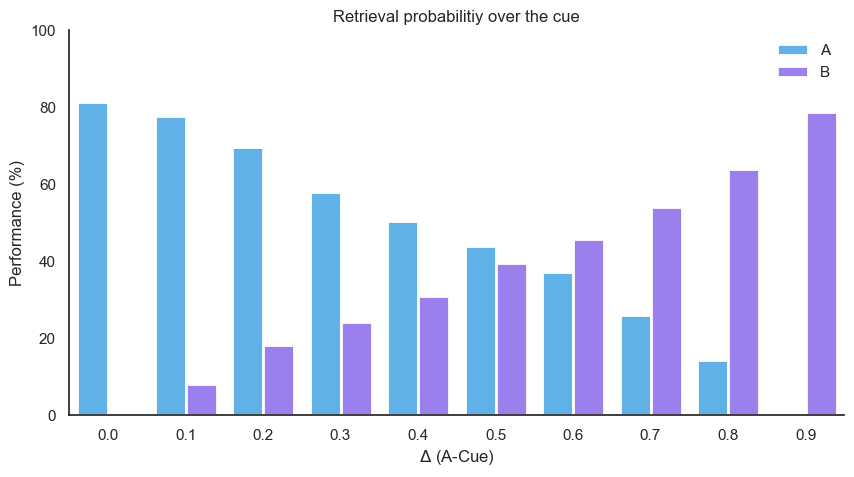

In [29]:
data_dic = {}
data_dic['$\Delta$ (A-Cue)'] = []
for n in range(2):
    data_dic['$\Delta$ (A-Cue)'] +=  list(np.around(0.1*np.array(range(10)),1))
data_dic['A / B'] = []
for n in range(10):
    data_dic['A / B'].append('A')
for n in range(10):
    data_dic['A / B'].append('B')
    
data_dic['Performance (%)'] = (list(Winner_A_fin) + list(Winner_B_fin))

df = pd.DataFrame(data_dic)

fig = plt.subplot(111)
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_theme(style='white')
ax = sns.barplot(data = df, x='$\Delta$ (A-Cue)', y='Performance (%)', palette={'A':palette[1],'B':palette[-3]}, hue=df['A / B'], linewidth=2, dodge=True)
plt.legend(loc='upper right', frameon=False)
plt.ylim([0,100])
plt.title('Retrieval probabilitiy over the cue')
ax.spines[['top', 'right']].set_visible(False)
plt.savefig('Fig-tradeoffbar.pdf', bbox_inches='tight')
plt.savefig('Fig-tradeoffbar.tiff', bbox_inches='tight', dpi=300)
plt.show()

In [30]:
Simlist_IN = []
Simlist_DG = []
Simlist_CA3 = []
Simlist_CA1 = []
Simlist_idx = []
# # 각 cue에 대해 발화한 각 영역의 엔그램 idx
for n in range(Num_cue*Repeat):
    temp = n // Repeat
    if Trial_CA1L[n] == 1:
        if Trial_CA3L[n] == 1:
            Simlist_IN.append(np.where(Cue_DataL[:,temp] !=0)[0])
            Simlist_DG.append(np.where(DG_E_listL[temp] >= 2)[0])
            Simlist_CA3.append(np.where(CA3_R_listL[n] >= 3)[0])
            Simlist_CA1.append(np.where(CA1_R_listL[n] >= 2)[0])
            Simlist_idx.append(temp)
            
# for n in range(Num_cue*Repeat):
#     temp = n // Repeat
#     if Trial_CA1N[n] == 1:
#         if Trial_CA3N[n] == 1:
#             Simlist_IN.append(np.where(Cue_DataN[:,temp] !=0)[0])
#             Simlist_DG.append(np.where(DG_E_listN[temp] >= 2)[0])
#             Simlist_CA3.append(np.where(CA3_R_listN[n] >= 3)[0])
#             Simlist_CA1.append(np.where(CA1_R_listN[n] >= 2)[0])
#             Simlist_idx.append(temp+100)

In [31]:
len(Simlist_idx)

2463

In [32]:
# 
Pair_IN = []
Pair_DG = []
Pair_CA3 = []
#Pair_CA1 = []
Pair_idx = []
idx = []

for i, comp in enumerate(Simlist_DG):
    temp = 1-cal_relative_overlap_DG(set(range(800)), set(comp), T_idx)
    #separation 됐으면
    #if temp > 0:
    Pair_DG.append(temp)
    #else:
    #    idx.append(i)
                       
# for i, comp in enumerate(Simlist_CA1):
#     #if i not in idx:
#         #Pair_CA1.append(1-cal_relative_overlap_CA1(set(range(16)), set(comp), T_idx))
#     Pair_CA1.append(1-cal_overlap(set(range(16)), set(np.where(Filt_idata[:,NN]!=0)[0]), set(comp)))
        
for i, comp in enumerate(Simlist_IN):
    #if i not in idx:
    Pair_IN.append(1-cal_overlap(set(range(16)), set(np.where(Filt_idata[:,NN]!=0)[0]), set(comp)))

for i, comp in enumerate(Simlist_CA3):
    #if i not in idx:
    #Pair_CA3.append(1-cal_relative_overlap_CA3(set(range(2400)), set(comp), T_idx))
    Pair_CA3.append(1-cal_overlap(set(range(2400)), set(comp), set(Af_py[144])))    
    
for i, comp in enumerate(Simlist_idx):
    #if i not in idx:        
    Pair_idx.append(comp)

In [33]:
Pair_IN_sum = np.zeros(Num_cue*2)
Pair_IN_idx = np.zeros(Num_cue*2)
for i, comp in enumerate(Pair_idx):
    Pair_IN_sum[comp] += Pair_IN[i]
    Pair_IN_idx[comp] += 1
    
Pair_IN_fin = Pair_IN_sum/Pair_IN_idx
Pair_IN_fin = Pair_IN_fin[~np.isnan(Pair_IN_fin)]

Pair_DG_sum = np.zeros(Num_cue*2)
Pair_DG_idx = np.zeros(Num_cue*2)
for i, comp in enumerate(Pair_idx):
    Pair_DG_sum[comp] += Pair_DG[i]
    Pair_DG_idx[comp] += 1
    
Pair_DG_fin = Pair_DG_sum/Pair_DG_idx
Pair_DG_fin = Pair_DG_fin[~np.isnan(Pair_DG_fin)]

Pair_CA3_sum = np.zeros(Num_cue*2)
Pair_CA3_idx = np.zeros(Num_cue*2)
for i, comp in enumerate(Pair_idx):
    Pair_CA3_sum[comp] += Pair_CA3[i]
    Pair_CA3_idx[comp] += 1
    
Pair_CA3_fin = Pair_CA3_sum/Pair_CA3_idx
Pair_CA3_fin = Pair_CA3_fin[~np.isnan(Pair_CA3_fin)]

# Pair_CA1_sum = np.zeros(Num_cue*2)
# Pair_CA1_idx = np.zeros(Num_cue*2)
# for i, comp in enumerate(Pair_idx):
#     Pair_CA1_sum[comp] += Pair_CA1[i]
#     Pair_CA1_idx[comp] += 1
    
# Pair_CA1_fin = Pair_CA1_sum/Pair_CA1_idx
# Pair_CA1_fin = Pair_CA1_fin[~np.isnan(Pair_CA1_fin)]

C:\Users\fiat_\AppData\Local\Temp\ipykernel_5836\3046759818.py:7: RuntimeWarning: invalid value encountered in divide
  Pair_IN_fin = Pair_IN_sum/Pair_IN_idx
C:\Users\fiat_\AppData\Local\Temp\ipykernel_5836\3046759818.py:16: RuntimeWarning: invalid value encountered in divide
  Pair_DG_fin = Pair_DG_sum/Pair_DG_idx
C:\Users\fiat_\AppData\Local\Temp\ipykernel_5836\3046759818.py:25: RuntimeWarning: invalid value encountered in divide
  Pair_CA3_fin = Pair_CA3_sum/Pair_CA3_idx


In [34]:
with open(path+'//module//Learned weights-tradeoff_encoding.pkl', 'rb') as file:
    DG_E_list = pickle.load(file)
    CA3_E_list = pickle.load(file)
    CA1_E_list = pickle.load(file)

In [35]:
np.where(CA1_E_list[0])

(array([ 12,  14,  15,  21,  22,  31,  35,  37,  40,  56,  59,  74,  77,
         87,  88,  93,  94,  96, 104, 109, 111, 113, 116, 122, 135, 136,
        141, 150, 157, 164, 166, 182, 186, 192, 193, 196], dtype=int64),)

In [36]:
np.where(CA1_E_list[1])

(array([  3,   7,  23,  27,  29,  32,  34,  39,  43,  55,  58,  62,  69,
         78,  86,  97, 101, 112, 118, 119, 123, 124, 137, 139, 144, 159,
        160, 163, 171, 173, 178, 189, 198], dtype=int64),)

In [37]:
CA1_A

NameError: name 'CA1_A' is not defined

In [38]:
Pair_CA1_fin = np.zeros(len(set(Pair_idx)))
for i, comp in enumerate(set(Pair_idx)):
    A_R = Winner_list[0,comp]
    B_R = Winner_list[1,comp]
    CA1_A = 1-cal_overlap(set(range(200)), set(np.where(CA1_E_list[0])[0]), set(np.where(CA1_E_list[0])[0]))
    CA1_B = 1-cal_overlap(set(range(200)), set(np.where(CA1_E_list[0])[0]), set(np.where(CA1_E_list[1])[0]))
    Pair_CA1_fin[i] = (A_R*CA1_A+B_R*CA1_B)/(A_R+B_R)

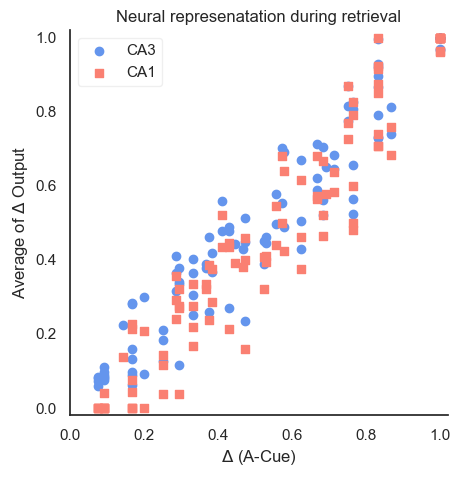

In [39]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(Pair_IN_fin, Pair_CA3_fin, color='cornflowerblue', label='CA3')
plt.scatter(Pair_IN_fin, Pair_CA1_fin, color='salmon', marker=',', label='CA1')

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')
plt.axis("square")
plt.xlim([0,1.02])
plt.ylim([-0.02,1.02])
plt.legend(loc='upper left', framealpha=0.3)
plt.xlabel('$\Delta$ (A-Cue)')
plt.ylabel('Average of $\Delta$ Output')

fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.title('Neural represenatation during retrieval')
plt.savefig('Cog-Tradeoff.pdf', bbox_inches='tight')
plt.savefig('Cog-Tradeoff.tiff', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
TEM3 = []
TEM1 = []
for i, comp in enumerate(Simlist_CA3):
    if Simlist_idx[i] == 60:
        te3 = 1-cal_overlap(set(range(2400)), set(Af_py[NN]), set(comp))
        TEM3.append(te3)
        if te3 < 0.3:
            te1 = 1-cal_overlap(set(range(200)), set(np.where(CA1_E_T[0])[0]), set(np.where(CA1_E_T[0])[0]))
        else:
            te1 = 1-cal_overlap(set(range(200)), set(np.where(CA1_E_T[0])[0]), set(np.where(CA1_E_list[Simlist_idx[i]])[0]))
        TEM1.append(te1)
        print(comp, np.round(te3, 3), np.round(te1, 3))

In [ ]:
a

In [ ]:
DeltaIN = []
#DeltaDG = []
DeltaCA3 = []
DeltaCA1 = []
Classfy_num = 40
for n in range(Classfy_num+1):
    DeltaIN.append([])
    #DeltaDG.append([])
    DeltaCA3.append([])
    DeltaCA1.append([])
    
for i, comp in enumerate(Pair_IN_fin):
    if comp == 0:
        DeltaIN[0].append(comp)
        #DeltaDG[0].append(Pair_DG_fin[i])
        DeltaCA3[0].append(Pair_CA3_fin[i])
        DeltaCA1[0].append(Pair_CA1_fin[i])
    for n in range(Classfy_num):    
        if (1/Classfy_num)*n < comp <= (1/Classfy_num)*n+(1/Classfy_num):
            DeltaIN[n+1].append(comp)
            #DeltaDG[n+1].append(Pair_DG_fin[i])
            DeltaCA3[n+1].append(Pair_CA3_fin[i])
            DeltaCA1[n+1].append(Pair_CA1_fin[i])

DeltaIN_final = np.zeros(len(DeltaIN))
#DeltaDG_final = np.zeros(len(DeltaDG))
DeltaCA3_final = np.zeros(len(DeltaCA3))
DeltaCA1_final = np.zeros(len(DeltaCA1))
for n in range(len(DeltaIN)):
    DeltaIN_final[n] = np.mean(DeltaIN[n])
    #DeltaDG_final[n] = np.mean(DeltaDG[n])
    DeltaCA3_final[n] = np.mean(DeltaCA3[n])
    DeltaCA1_final[n] = np.mean(DeltaCA1[n])

In [ ]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(DeltaIN_final, DeltaCA3_final, color='cornflowerblue', label='CA3')
plt.scatter(DeltaIN_final, DeltaCA1_final, color='salmon', marker=',', label='CA1')
#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')

plt.axis("square")
plt.xlim([0,1.02])
plt.ylim([-0.02,1.02])
plt.legend(loc='upper left')
plt.xlabel('$\Delta$ (A-Cue)')
plt.ylabel('Average of $\Delta$ Output')

fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.title('Neural represenatation during retrieval')
plt.savefig('Cog-Tradeoff.pdf', bbox_inches='tight')
plt.show()

In [ ]:
a

In [ ]:
A = set(np.where(Filt_idata[:,144])[0])
B = set(np.where(Filt_idata[:,327])[0])
# 여기는 Filt_idata에 대한 idx값들 200개
with open(path+'//module//Cue_Tradeoff_vf0.pkl', 'rb') as file:
    Cue_DataL = pickle.load(file)
# 여기는 Filt_idata에 대한 idx값들 200개
with open(path+'//module//Cue_Tradeoff_vf1.pkl', 'rb') as file:
    Cue_DataN = pickle.load(file)
    

In [ ]:
for n in range(100):
    withA = cal_overlap(set(range(16)), A, set(np.where(Cue_DataN[:,n])[0]))
    withB = cal_overlap(set(range(16)), B, set(np.where(Cue_DataN[:,n])[0]))
    print(withA, withB)

In [ ]:
np.shape(Cue_DataL)

In [ ]:
np.shape(Cue_DataN)

In [ ]:
a

In [ ]:
a

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
# Define the logistic function
def logistic_function(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Example data (replace this with your actual data)
x_data = np.array(Pair_IN_fin)
y_data = np.array(Pair_CA3_fin)

# Initial guess for the parameters L, x0, k, b
initial_guess = [1, 0.5, 1, 0]

# Fit the logistic function to the data
popt, pcov = curve_fit(logistic_function, x_data, y_data, p0=initial_guess)

# Get the parameters from the fit
L, x0, k, b = popt

# Generate x values for the fit line
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = logistic_function(x_fit, L, x0, k, b)

# Plot the original data and the fit
plt.scatter(x_data, y_data, label='Data', color='red')
plt.plot(x_fit, y_fit, label='Logistic Fit', color='blue')
plt.plot(x,x, color='black')
plt.xlabel('∆ Input')
plt.ylabel('∆ Output')
plt.legend()
plt.show()

# Print the parameters
print(f"L = {L}, x0 = {x0}, k = {k}, b = {b}")

In [ ]:
16*15*14*13*12*11/(8*7*6*5*4*3*2)

In [ ]:
DeltaIN = []
DeltaDG = []
DeltaCA3 = []
Classfy_num = 30
for n in range(Classfy_num):
    DeltaIN.append([])
    DeltaDG.append([])
    DeltaCA3.append([])
    
for i, comp in enumerate(Pair_IN_fin):
    for n in range(Classfy_num):    
        if (1/Classfy_num)*n < comp <= (1/Classfy_num)*n+(1/Classfy_num):
            DeltaIN[n].append(comp)
            DeltaDG[n].append(Pair_DG_fin[i])
            DeltaCA3[n].append(Pair_CA3_fin[i])
            
DeltaIN_fin = np.zeros(Classfy_num)
DeltaDG_fin = np.zeros(Classfy_num)
DeltaCA3_fin = np.zeros(Classfy_num)
for n in range(Classfy_num):
    DeltaIN_fin[n] = np.mean(DeltaIN[n])
    DeltaDG_fin[n] = np.mean(DeltaDG[n])
    DeltaCA3_fin[n] = np.mean(DeltaCA3[n])

In [ ]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(DeltaIN_fin, DeltaCA3_fin, color='salmon', label='CA3')
#plt.scatter(DeltaIN, DeltaCA1, color='black', label='CA1')

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
plt.plot(x,x, color='black')
#plt.xlim([0,1])
#plt.ylim([0,1.2])
plt.xlabel('$\Delta$ Input')
plt.ylabel('$\Delta$ Output')
plt.axis("square")
plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
#plt.savefig('Discrimination degreeF-relv2-30.png', bbox_inches='tight')
plt.show()

In [ ]:
Overlap_I = []
Overlap_DG = []
Overlap_CA3 = []
Overlap_CA1 = []
Classfy_num = 96
for n in range(Classfy_num+1):
    Overlap_I.append([])
    Overlap_DG.append([])
    Overlap_CA3.append([])
    Overlap_CA1.append([])
    
for i, comp in enumerate(Pair_IN_fin):
    if comp == 0:
        Overlap_I[0].append(1-comp)
        Overlap_DG[0].append(1-Pair_DG_fin[i])
        Overlap_CA3[0].append(1-Pair_CA3_fin[i])
        Overlap_CA1[0].append(1-Pair_CA1_fin[i])
    for n in range(Classfy_num):    
        if (1/Classfy_num)*n < comp <= (1/Classfy_num)*n+(1/Classfy_num):
            Overlap_I[n+1].append(1-comp)
            Overlap_DG[n+1].append(1-Pair_DG_fin[i])
            Overlap_CA3[n+1].append(1-Pair_CA3_fin[i])
            Overlap_CA1[n+1].append(1-Pair_CA1_fin[i])
            
DeltaIN = []
DeltaDG = []
DeltaCA3 = []
DeltaCA1 = []
for i, comp in enumerate(Overlap_I):
    DeltaIN.append(1-np.mean(comp))
    DeltaDG.append(1-np.mean(Overlap_DG[i]))
    DeltaCA3.append(1-np.mean(Overlap_CA3[i]))
    DeltaCA1.append(1-np.mean(Overlap_CA1[i]))

In [ ]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
#plt.scatter(DeltaIN, DeltaDG, color='cornflowerblue', label='DG')
plt.scatter(DeltaIN, DeltaCA3, color='salmon', label='CA3')
#plt.scatter(DeltaIN, DeltaCA1, color='black', label='CA1')

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
plt.plot(x,x, color='black')
#plt.xlim([0,1])
#plt.ylim([0,1.2])
plt.xlabel('$\Delta$ Input')
plt.ylabel('$\Delta$ Output')
plt.axis("square")
plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.savefig('Discrimination degreeF-relv2-30.png', bbox_inches='tight')
plt.show()

In [ ]:
DeltaIN